# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "P1_example.mp4" (also contained in this repository) to see what the output should look like. 

Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the lines in the image, and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="laneLines_thirdPass.jpg" width="480" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output image should look like this (more or less) after line detection </p> 
 </figcaption>
</figure>

In [32]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


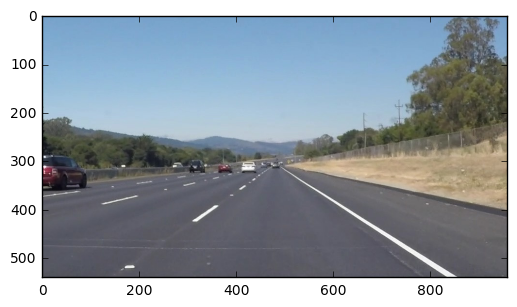

In [33]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [34]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    Draws `lines` with `color` and `thickness`.
    
    Lines are drawn on the image inplace (mutates the image).
    """
    #I want to find two lines, so I'll take the average of all the lines found.
    #I'll assume that one line will have positive slope, and the other will have negative
    #These two arrays will hold the slopes of the lines found to the left (positive)
    #and the right (negative)
    left_lines = []
    right_lines = []
    left_intersect = []
    right_intersect = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #find slope
            slope = (y2-y1) / (x2-x1)
            #filter out nearly horizontal lines
            if slope > 0.25:
                left_lines.append(slope)
                left_intersect.append(y1 - slope * x1)
            elif slope < -0.25:
                right_lines.append(slope)
                right_intersect.append(y1 - slope * x1)
    #if there are no values in these arrays, the average give NaN, so I'm going 
    #to make something up so it doesn't fail in that case
    if len(left_lines) == 0:
        left_lines = [0.1]
    if len(right_lines) == 0:
        right_lines = [0.1]
    if len(left_intersect) == 0:
        left_intersect = [0.1]
    if len(right_intersect) == 0:
        right_intersect = [0.1]
    
    left_slope = np.average(left_lines)
    right_slope = np.average(right_lines)
    left_b = np.average(left_intersect)
    right_b = np.average(right_intersect)
    #the y-values should be easy - I always want them to start at the bottom of the picture
    #and end at the top of our region of interest
    y1 = img.shape[0]
    y2 = int(round(y1 * 0.6))
    
    #calculate the x-values from the slope and the y
    x1_right = get_round_int_x(y1, right_slope, right_b)
    x2_right = get_round_int_x(y2, right_slope, right_b)
    x1_left = get_round_int_x(y1, left_slope, left_b)
    x2_left = get_round_int_x(y2, left_slope, left_b)
    
    #draw my two lines!
    cv2.line(img, (x1_right, y1), (x2_right, y2), color, thickness)
    cv2.line(img, (x1_left, y1), (x2_left, y2), color, thickness)
    
def get_round_int_x(y, m, b):
    return int(round((y - b)/m))

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def stack_with_zeros(img):
    """ used to allow the lines image (which is 1 color channel) to 
    be added to the original image (which is 3 color channel)
    """
    zeros = np.zeros(img.shape, dtype=np.uint8)
    return np.dstack((img, zeros, zeros))
    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

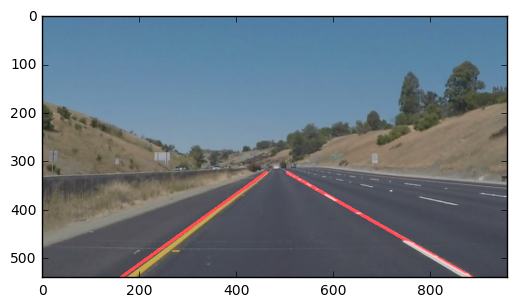

In [35]:
import os
images = os.listdir("test_images/")

def work_on_image(filename, origin_dir, dest_dir):
    image = mpimg.imread(origin_dir + filename)
    final_img = find_lanes_in_image(image)
    cv2.imwrite(dest_dir + filename, final_img)
    plt.imshow(final_img)
    
def find_lanes_in_image(image):
    imshape = image.shape
    #define the shape of the mask for the region of interest with vertices
    vertices = np.array([[(0,imshape[0]),(imshape[1]*0.45, imshape[0]*0.6), (imshape[1]*0.55, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    #first convert to grayscale:
    gray1 = grayscale(image)
    #canny edge detection
    canny1 = canny(gray1, 50, 100)
    #gaussian blurring
    gauss1 = gaussian_noise(canny1, 7)
    region1 = region_of_interest(gauss1, vertices)
    #run the hough transform on edge-detected image (this one is also masked for region of interest)
    #should output an array of lines detected in the image
    lines1 = hough_lines(region1, 1, np.pi/180, 50, 50, 40)
    #combine the lines and the original image
    return weighted_img(stack_with_zeros(lines1), image)
    
    
    
for file in images:
    work_on_image(file, 'test_images/', 'written_images/')
    



run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
def process_image(image):
    
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    return find_lanes_in_image(image)

Let's try the one with the solid white lane on the right first ...

In [38]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 27.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.55 s, sys: 716 ms, total: 6.27 s
Wall time: 8.74 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [39]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [40]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:26<00:00, 26.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 18.8 s, sys: 1.98 s, total: 20.8 s
Wall time: 27.1 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


My algorithm is likely to fail when the lanes are perpendicular to the camera, like when turning onto a perpendicular street. This is because I wrote it such that lines detected with near 0 slope are ignored. It may also fail when changing lanes, because I'm always assuming that one line will have a positive slope, and the other a negative due to the typical camera angle and perspective.

My algorithm worked fairly well for the two simpler examples, though they were pretty shaky - my algorithm could use some tweaking to smooth out that action. The challenge video also demonstrated how fragile my pipeline was. In particular there was one frame where my algorithm didn't detect _any_ lines at all for one side of the lane, so my method of taking the average created a NaN value and the process crashed. Because of this, I added in some naive error-handling, but clearly more work could be done to find a more elegant solution.

The challenge video also made it clear that when large shadows cross the path, or sudden changes in pavement color occur, the line detection can get a bit polluted. Potentially doing more work on detecting color consistency and predicting likely behavior of lane positions to give more weight to the appropriate lines would help.


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [30]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

720 0.633001461319 -4.05310333114
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  1%|          | 2/251 [00:00<00:22, 11.24it/s]

720 0.633001461319 -4.05310333114
720 0.623965450805 3.40094131465
720 0.606061333908 22.9036328558


  2%|▏         | 4/251 [00:00<00:22, 10.93it/s]

720 0.622884443162 9.94308713757
720 0.579523227503 46.1343364831


  2%|▏         | 6/251 [00:00<00:22, 11.12it/s]

720 0.611621328075 19.9115007041


  3%|▎         | 7/251 [00:00<00:22, 10.70it/s]

720 0.612021590625 17.5032599842
720 0.657714933594 -21.7103765454


  4%|▎         | 9/251 [00:00<00:22, 10.86it/s]

720 0.651697853052 -19.4623422976


  4%|▍         | 11/251 [00:00<00:21, 11.11it/s]

720 0.629170120908 1.68137055819
720 0.592105583446 37.7495156551


  5%|▍         | 12/251 [00:01<00:22, 10.68it/s]

720 0.610237785265 17.4847331322


  5%|▌         | 13/251 [00:01<00:23, 10.17it/s]

720 0.639631986651 -11.1919420126
720 0.641126597475 -9.9861237372


  6%|▌         | 15/251 [00:01<00:23, 10.22it/s]

720 0.643478700547 -10.5940531542


  6%|▋         | 16/251 [00:01<00:25,  9.33it/s]

720 0.637486732369 -2.47550108637


  7%|▋         | 17/251 [00:01<00:30,  7.75it/s]

720 0.634811651516 -0.666694420126
720 0.628510153739 3.45202559667


  8%|▊         | 19/251 [00:02<00:34,  6.73it/s]

720 0.617293610358 16.6983804912


  8%|▊         | 20/251 [00:02<00:32,  7.01it/s]

720 0.6671382678 -26.6555853788


  8%|▊         | 21/251 [00:02<00:33,  6.82it/s]

720 0.601019536349 27.8413825704


  9%|▉         | 22/251 [00:02<00:34,  6.56it/s]

720 0.658073073461 -22.2261944437


  9%|▉         | 23/251 [00:02<00:35,  6.50it/s]

720 0.605273041253 22.3528881859


 10%|▉         | 24/251 [00:02<00:35,  6.44it/s]

720 0.636322369691 -3.7020931477


 10%|▉         | 25/251 [00:02<00:34,  6.47it/s]

720 0.650254809297 -16.7500617878


 10%|█         | 26/251 [00:03<00:32,  6.97it/s]

720 0.630967082945 2.87545380807


 11%|█         | 28/251 [00:03<00:28,  7.82it/s]

720 0.656005481187 -18.9030778778
720 0.698780257218 -53.0655731915


 12%|█▏        | 30/251 [00:03<00:30,  7.28it/s]

720 0.649633453418 -12.1542376578
720 0.675618335286 -34.4049556947


 13%|█▎        | 32/251 [00:03<00:28,  7.71it/s]

720 0.645955084884 -9.74305434373
720 0.64851175533 -11.8334042185


 14%|█▎        | 34/251 [00:04<00:26,  8.11it/s]

720 0.648290216769 -13.6773467512
720 0.601953401943 24.0015807379


 14%|█▍        | 36/251 [00:04<00:29,  7.25it/s]

720 0.636980478572 -3.74742047423
720 0.599387499291 27.223146366


 15%|█▌        | 38/251 [00:04<00:30,  7.00it/s]

720 0.601101202786 24.3549397383
720 0.599552936399 24.5368776489


 16%|█▌        | 40/251 [00:04<00:26,  7.99it/s]

720 0.656919157134 -18.8421800643
720 0.595183338795 28.6262800411
720 0.584897828305 33.990510216


 17%|█▋        | 43/251 [00:05<00:23,  8.72it/s]

720 0.607702313301 19.5599891554
720 0.575986510281 50.547510047


 18%|█▊        | 45/251 [00:05<00:22,  9.01it/s]

720 0.663374999497 -25.7545425054
720 0.646302570069 4.25885319063


 19%|█▊        | 47/251 [00:05<00:23,  8.65it/s]

720 0.559764069797 55.6312004321
720 0.619121694376 8.88519360179


 20%|█▉        | 49/251 [00:05<00:23,  8.42it/s]

720 0.604358772189 19.3994996657
720 0.614617909604 13.8896351313


 20%|██        | 51/251 [00:06<00:23,  8.38it/s]

720 0.6179124486 11.8448885908
720 0.572374683308 47.5052524307


 21%|██        | 53/251 [00:06<00:23,  8.31it/s]

720 0.564823779261 49.175555289
720 0.644129622202 2.16266292642


 22%|██▏       | 55/251 [00:06<00:24,  8.13it/s]

720 0.607732077285 19.2343247523
720 0.621507146345 11.6983600269


 23%|██▎       | 57/251 [00:06<00:24,  8.06it/s]

720 0.619120671849 12.3298414544
720 0.60393669909 26.3942188331


 24%|██▎       | 59/251 [00:07<00:23,  8.15it/s]

720 0.647763216907 -15.0353118005
720 0.646506642792 -16.2412917959


 24%|██▍       | 61/251 [00:07<00:22,  8.52it/s]

720 0.607133888429 18.908598924
720 0.64066832576 -10.9091666069


 25%|██▌       | 63/251 [00:07<00:23,  8.07it/s]

720 0.605780518961 18.9502503431
720 0.621095443363 4.18671350904


 26%|██▌       | 65/251 [00:07<00:21,  8.52it/s]

720 0.589836516485 32.0987592079
720 0.586144191938 34.6695725891


 27%|██▋       | 67/251 [00:07<00:23,  7.85it/s]

720 0.619536699392 8.9352688495
720 0.610662073273 15.0162114614


 27%|██▋       | 69/251 [00:08<00:23,  7.69it/s]

720 0.59013009435 33.0357118949
720 0.626311363444 0.564379018281


 28%|██▊       | 71/251 [00:08<00:27,  6.45it/s]

720 0.58272920791 37.5091478844
720 0.602358853214 18.1900689526


 29%|██▉       | 73/251 [00:08<00:28,  6.16it/s]

720 0.593534687382 26.5708560448
720 0.592769904253 26.4371103862


 30%|██▉       | 75/251 [00:09<00:29,  5.95it/s]

720 0.591895032744 25.997950723
720 0.568388184268 45.6211528428


 31%|███       | 77/251 [00:09<00:27,  6.28it/s]

720 0.586244314546 33.5535632196
720 0.518774250602 99.1373524245


 31%|███▏      | 79/251 [00:09<00:24,  6.91it/s]

720 0.578307866546 39.2642702156
720 0.55066355238 62.015743014


 32%|███▏      | 81/251 [00:10<00:23,  7.24it/s]

720 0.570371886717 43.018372763
720 0.573643395668 43.4937478398


 33%|███▎      | 83/251 [00:10<00:23,  7.29it/s]

720 0.56993833033 43.7434067099
720 0.580531115798 36.2244227456


 34%|███▍      | 85/251 [00:10<00:23,  6.99it/s]

720 0.588089125488 25.2400430142
720 0.548534906753 63.2254006005


 35%|███▍      | 87/251 [00:10<00:23,  6.96it/s]

720 0.469230042874 126.552870524
720 0.488333542563 118.091564064


 35%|███▌      | 89/251 [00:11<00:24,  6.56it/s]

720 0.501368026628 107.559621807
720 0.487083752724 121.791530578


 36%|███▋      | 91/251 [00:11<00:26,  5.98it/s]

720 0.474676252221 135.588475529
720 0.392382227222 217.482526987


 37%|███▋      | 92/251 [00:11<00:27,  5.70it/s]

720 0.474296208713 138.74291481


 37%|███▋      | 93/251 [00:12<00:32,  4.85it/s]

720 1.44062641715 -555.060472272


 37%|███▋      | 94/251 [00:12<00:33,  4.65it/s]

720 0.535742381708 75.8098388237


 38%|███▊      | 95/251 [00:12<00:35,  4.45it/s]

720 0.539213572906 74.1092549729


 38%|███▊      | 96/251 [00:12<00:38,  4.06it/s]

720 0.562201247536 49.8454688627


 39%|███▉      | 98/251 [00:13<00:37,  4.08it/s]

720 0.542721492717 72.3651741729
720 0.571121178392 55.348385765


 39%|███▉      | 99/251 [00:13<00:34,  4.44it/s]

720 0.511365006292 99.8957205587
720 0.440733617446 168.357359724


 41%|████      | 102/251 [00:14<00:27,  5.36it/s]

720 0.552183915103 59.5882619922
720 0.553497253672 59.3640283193


 41%|████▏     | 104/251 [00:14<00:24,  6.02it/s]

720 0.512060906337 97.8444514435
720 0.549885674884 67.325010515


 42%|████▏     | 105/251 [00:14<00:24,  5.90it/s]

720 0.580128837418 41.6339072426


 42%|████▏     | 106/251 [00:14<00:26,  5.56it/s]

720 0.463098695596 151.588459215


 43%|████▎     | 107/251 [00:15<00:28,  5.06it/s]

720 0.596312210195 24.7187186334


 43%|████▎     | 108/251 [00:15<00:31,  4.53it/s]

720 0.585620591373 33.1302550785


 43%|████▎     | 109/251 [00:15<00:33,  4.27it/s]

720 0.555843904898 61.9509602944
720 0.380256310994 214.032076997


 45%|████▍     | 112/251 [00:16<00:25,  5.35it/s]

720 0.506758422685 98.288957626
720 0.463474501808 147.714734246


 45%|████▌     | 114/251 [00:16<00:22,  6.09it/s]

720 0.458749955561 174.738840273
720 0.45346833195 142.674519159


 46%|████▌     | 116/251 [00:16<00:20,  6.55it/s]

720 0.453598434698 147.19839844
720 0.47478287311 142.031065286


 47%|████▋     | 118/251 [00:17<00:21,  6.06it/s]

720 0.423648307437 193.196063507
720 0.35620881173 291.653027484


 48%|████▊     | 120/251 [00:17<00:22,  5.91it/s]

720 0.295142902907 299.553304957
720 0.547860985638 87.2987969505


 49%|████▊     | 122/251 [00:17<00:23,  5.53it/s]

720 0.321664901105 286.578171322
720 0.376280635787 240.475153901


 49%|████▉     | 124/251 [00:18<00:21,  6.01it/s]

720 0.818165150554 -137.844891051
720 0.825493612079 -149.56068525


 50%|█████     | 126/251 [00:18<00:19,  6.54it/s]

720 0.419853809785 189.305030076
720 0.325594728928 276.650999892


 51%|█████     | 128/251 [00:18<00:18,  6.61it/s]

720 0.431254988252 166.10039676
720 0.473631913902 141.674991222


 52%|█████▏    | 130/251 [00:18<00:18,  6.64it/s]

720 0.456249146593 155.765884647
720 0.488870731092 128.969321882


 53%|█████▎    | 132/251 [00:19<00:18,  6.40it/s]

720 0.747532460209 -98.7804173027
720 0.468553004081 156.807199877


 53%|█████▎    | 134/251 [00:19<00:21,  5.45it/s]

720 0.516279648695 98.5377206522
720 0.465255588808 183.404986443


 54%|█████▍    | 135/251 [00:19<00:20,  5.57it/s]

720 0.400320860413 210.10030887
720 0.366650485035 398.121732091


 55%|█████▍    | 138/251 [00:20<00:18,  5.97it/s]

720 0.50406492195 111.824353102
720 0.480842105263 115.700210526


 56%|█████▌    | 140/251 [00:20<00:17,  6.32it/s]

720 0.44334241617 181.297632183
720 0.356612722327 224.954497475


 57%|█████▋    | 142/251 [00:20<00:16,  6.69it/s]

720 0.48841754719 124.653742855
720 0.1 0.1


 57%|█████▋    | 144/251 [00:21<00:16,  6.35it/s]

720 0.487297921478 141.64665127
720 0.46834551595 228.448312976


 58%|█████▊    | 145/251 [00:21<00:17,  6.01it/s]

720 0.442100272609 137.223598435


 58%|█████▊    | 146/251 [00:21<00:21,  4.93it/s]

720 0.306532663317 278.030150754


 59%|█████▊    | 147/251 [00:22<00:22,  4.55it/s]

720 0.397876232414 367.154893738


 59%|█████▉    | 148/251 [00:22<00:24,  4.20it/s]

720 0.555366251563 69.8379853354


 59%|█████▉    | 149/251 [00:22<00:26,  3.84it/s]

720 0.483541368083 134.259846655
720 0.404892147111 209.883885205


 61%|██████    | 152/251 [00:23<00:19,  5.11it/s]

720 0.383474546917 220.040055615
720 0.545672920716 69.6117602211


 61%|██████▏   | 154/251 [00:23<00:17,  5.46it/s]

720 0.509758009383 91.5312154297
720 0.528010383704 90.1037348263


 62%|██████▏   | 155/251 [00:23<00:19,  5.03it/s]

720 0.712918694748 -61.7962231577


 62%|██████▏   | 156/251 [00:24<00:21,  4.47it/s]

720 0.574243269467 45.122727026


 63%|██████▎   | 158/251 [00:24<00:19,  4.81it/s]

720 0.474065977768 130.442615929
720 0.5011385664 112.183173948


 63%|██████▎   | 159/251 [00:24<00:17,  5.17it/s]

720 0.522552583438 86.2638070073


 64%|██████▎   | 160/251 [00:24<00:18,  4.87it/s]

720 0.567606030761 75.3739911967


 64%|██████▍   | 161/251 [00:25<00:19,  4.64it/s]

720 0.649053067999 -10.6731153682


 65%|██████▍   | 163/251 [00:25<00:17,  5.04it/s]

720 0.639265039124 8.94319502037
720 0.677769043207 -29.5879249327


 66%|██████▌   | 165/251 [00:25<00:14,  5.93it/s]

720 0.669643174796 -27.1999010041
720 0.685668330217 -5.95170645295


 67%|██████▋   | 167/251 [00:25<00:13,  6.35it/s]

720 0.687633368216 -40.3174142805
720 0.674248602476 -31.3291758053


 67%|██████▋   | 169/251 [00:26<00:12,  6.78it/s]

720 0.639397396958 -2.2816247226
720 0.661534762523 -17.4413885915


 68%|██████▊   | 171/251 [00:26<00:13,  5.76it/s]

720 0.654860892947 -9.15839011632
720 0.636201188491 6.18445651881


 69%|██████▉   | 173/251 [00:26<00:12,  6.38it/s]

720 0.649305774303 -6.2005299666
720 0.661761650774 -20.9762783687


 70%|██████▉   | 175/251 [00:27<00:11,  6.61it/s]

720 0.638804781011 -2.15011344878
720 0.661323769167 -23.3047618883


 71%|███████   | 177/251 [00:27<00:11,  6.67it/s]

720 0.646918152924 -14.2865922886
720 0.64697740718 -13.92056149


 71%|███████▏  | 179/251 [00:27<00:10,  6.94it/s]

720 0.674426811738 -34.0509618594
720 0.67308143258 -30.3699959612


 72%|███████▏  | 181/251 [00:28<00:10,  6.91it/s]

720 0.656136017478 -17.3117697666
720 0.621662963257 5.86895021809


 73%|███████▎  | 182/251 [00:28<00:10,  6.84it/s]

720 0.647805009076 -13.3891097871


 73%|███████▎  | 184/251 [00:28<00:11,  6.00it/s]

720 0.613367363801 15.7161139961
720 0.585811289702 37.8636786


 74%|███████▍  | 186/251 [00:28<00:10,  6.36it/s]

720 0.596750822987 27.6456735168
720 0.664780198307 -29.2771336465


 75%|███████▍  | 188/251 [00:29<00:09,  6.49it/s]

720 0.646852595507 -13.7740176867
720 0.613313007671 14.9141822717


 76%|███████▌  | 190/251 [00:29<00:09,  6.64it/s]

720 0.659147376471 -24.5683129791
720 0.629676163606 -3.32217622413


 76%|███████▋  | 192/251 [00:29<00:08,  6.70it/s]

720 0.60959396185 14.9148484627
720 0.611216413129 11.6626446765


 77%|███████▋  | 194/251 [00:30<00:08,  6.83it/s]

720 0.639092127703 -10.4965393629
720 0.585949765821 32.9090432347


 78%|███████▊  | 196/251 [00:30<00:08,  6.74it/s]

720 0.615147618013 11.6910643524
720 0.567475668803 49.2645390945


 79%|███████▉  | 198/251 [00:30<00:07,  6.96it/s]

720 0.632040489403 -5.90481888863
720 0.640843682422 -14.4544729732


 80%|███████▉  | 200/251 [00:30<00:07,  6.88it/s]

720 0.626629970231 -1.94741312823
720 0.633653985017 -5.6402498408


 80%|████████  | 201/251 [00:31<00:08,  6.16it/s]

720 0.62685099225 0.416849578858


 80%|████████  | 202/251 [00:31<00:09,  5.42it/s]

720 0.601806050522 21.8500278465


 81%|████████  | 203/251 [00:31<00:09,  5.23it/s]

720 0.5929619966 27.8035978352


 81%|████████▏ | 204/251 [00:31<00:09,  4.96it/s]

720 0.597637365887 22.2532047626


 82%|████████▏ | 205/251 [00:32<00:09,  4.95it/s]

720 0.548601890006 65.0524837875


 82%|████████▏ | 206/251 [00:32<00:09,  4.73it/s]

720 0.615937181918 14.3922839674


 82%|████████▏ | 207/251 [00:32<00:09,  4.54it/s]

720 0.591205020344 36.0997663202


 83%|████████▎ | 208/251 [00:32<00:09,  4.41it/s]

720 0.589272341086 37.1950242199


 83%|████████▎ | 209/251 [00:32<00:09,  4.38it/s]

720 0.612650933605 11.5506237941


 84%|████████▎ | 210/251 [00:33<00:09,  4.39it/s]

720 0.645236207774 -15.5389627595


 84%|████████▍ | 211/251 [00:33<00:09,  4.21it/s]

720 0.607305122554 16.4536802694


 84%|████████▍ | 212/251 [00:33<00:09,  4.31it/s]

720 0.602348190894 18.6224127519
720 0.606438491593 16.5237873367


 86%|████████▌ | 215/251 [00:34<00:07,  5.06it/s]

720 0.60637370239 13.3096187894
720 0.585826304328 30.8342963916


 86%|████████▋ | 217/251 [00:34<00:06,  5.38it/s]

720 0.609009627069 13.2929480882
720 0.62272724722 0.576486723554


 87%|████████▋ | 219/251 [00:34<00:05,  6.23it/s]

720 0.619387901933 3.99994209984
720 0.587784537681 30.597928097


 88%|████████▊ | 221/251 [00:35<00:04,  6.92it/s]

720 0.570808303235 44.0816064123
720 0.514055215097 95.6307273318


 89%|████████▉ | 223/251 [00:35<00:03,  7.17it/s]

720 0.499001354011 109.688486479
720 0.605972559237 15.6965025162


 90%|████████▉ | 225/251 [00:35<00:03,  7.16it/s]

720 0.582408689633 37.2985302863
720 0.614470938127 11.3732164896


 90%|█████████ | 227/251 [00:35<00:03,  7.21it/s]

720 0.59609029938 30.1114423567
720 0.530485866758 85.4366013832


 91%|█████████ | 229/251 [00:36<00:02,  7.39it/s]

720 0.651418311178 -13.7989035392
720 0.567503527898 58.9862426563


 92%|█████████▏| 230/251 [00:36<00:02,  7.23it/s]

720 0.57810103071 43.0886350046


 92%|█████████▏| 231/251 [00:36<00:03,  6.33it/s]

720 0.624113886079 5.8929205422


 92%|█████████▏| 232/251 [00:36<00:03,  5.80it/s]

720 0.65299332384 -21.283512422
720 0.57951529049 40.8033713113


 94%|█████████▎| 235/251 [00:37<00:02,  5.55it/s]

720 0.604348174369 19.3016058217
720 0.616535826638 7.19065950845


 94%|█████████▍| 237/251 [00:37<00:02,  6.22it/s]

720 0.615267125557 8.37152356726
720 0.611015081293 10.3252478796


 95%|█████████▌| 239/251 [00:37<00:01,  6.86it/s]

720 0.619765509786 3.22188745927
720 0.564895073842 52.9026285271


 96%|█████████▌| 241/251 [00:38<00:01,  7.23it/s]

720 0.625478440115 2.38611621632
720 0.570458192203 48.9868730841


 97%|█████████▋| 243/251 [00:38<00:01,  6.64it/s]

720 0.582541926911 42.4740045802
720 0.597702335551 23.2511703655


 97%|█████████▋| 244/251 [00:38<00:01,  6.46it/s]

720 0.57210976177 46.4981411375
720 0.594893285091 31.5494435959


 98%|█████████▊| 247/251 [00:39<00:00,  5.80it/s]

720 0.616706072414 11.3506541527
720 0.632848969796 -0.728602308012


 99%|█████████▉| 249/251 [00:39<00:00,  5.73it/s]

720 0.598470903814 26.2140172116
720 0.604389092059 23.918630381


100%|██████████| 251/251 [00:39<00:00,  6.41it/s]

720 0.579797975192 41.1973104704
720 0.578673740358 43.155217786


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 31 s, sys: 2.03 s, total: 33 s
Wall time: 41.5 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))